# 05-Trip Duration Estimation



In [1]:
import numpy as np
import osmnx as ox
import geopandas as gpd
import networkx as nx
import folium
import numba
import matplotlib.pyplot as plt

from itertools import pairwise
from folium.vector_layers import PolyLine, CircleMarker
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from numba import jit
from db.api import EVedDb
from tqdm.notebook import tqdm_notebook as tqdm

The first step in this notebook is to load the Ann Arbor road network graph using the [OSMnx](https://osmnx.readthedocs.io/en/stable/) package. Note that we are not requesting the simplifications to get better trip endpoint matches.

In [2]:
g = ox.graph_from_place('Ann Arbor, Michigan', network_type='drive', simplify=False)

Plot the city's graph.

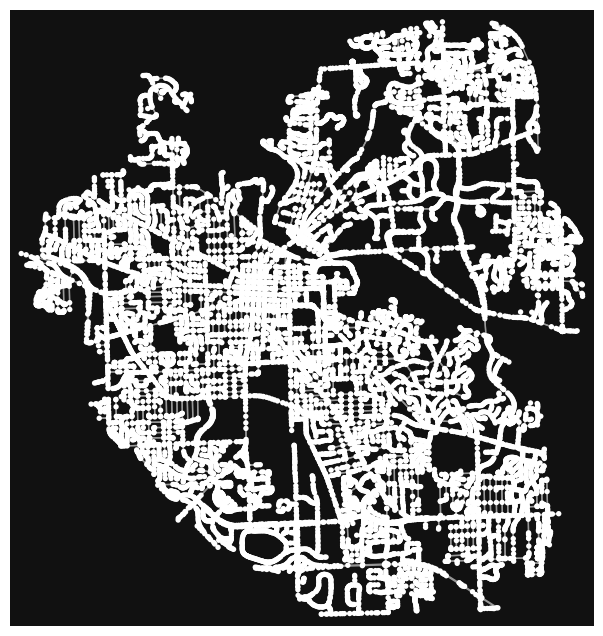

In [3]:
city = ox.plot_graph(g)

Add edge speeds to the graph. This will allow us to compare the speed inferred from the actual data to the theoretical speed.

In [4]:
g = ox.add_edge_speeds(g)

Add travel times to the edge properties.

In [5]:
g = ox.add_edge_travel_times(g)

Edge bearings are essential for querying the actual speed vectors. We will only sample speed vectors with a maximum 5 degrees deviation from the edge bearings.

In [6]:
g = ox.bearing.add_edge_bearings(g)

The code below was slightly adapted from https://max-coding.medium.com/osmnx-part-1-loading-data-from-open-street-maps-and-finding-shortest-route-between-two-points-5bb073b0a27d

In [7]:
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', 
                user_agent="QuadKey speedster").to_crs(crs)
    return geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x

Establish the start and end addresses for the route.

In [8]:
addr_ini = "122 N Thayer St, Ann Arbor, MI 48104, USA"
addr_end = "1431 Ardmoor Ave, Ann Arbor, MI 48103, USA"

Geocode the addresses into latitude and longitude coordinates.

In [9]:
loc_ini = geocode_address(addr_ini)
loc_end = geocode_address(addr_end)

Find the closest nodes in the graph.

In [10]:
node_ini = ox.distance.nearest_nodes(g, loc_ini[1], loc_ini[0])
node_end = ox.distance.nearest_nodes(g, loc_end[1], loc_end[0])

Calculate the route

In [11]:
route = nx.shortest_path(g, node_ini, node_end, weight='travel_time')

The `fit_bounding_box` function fits the map view from a list of coordinates.

In [12]:
def fit_bounding_box(html_map, bb_list):
    if isinstance(bb_list, list):
        ll = np.array(bb_list)
    else:
        ll = bb_list
        
    min_lat, max_lat = ll[:, 0].min(), ll[:, 0].max()
    min_lon, max_lon = ll[:, 1].min(), ll[:, 1].max()
    html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return html_map

Draw the map route from the graph information.

In [13]:
def map_route(g, route):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        CircleMarker((loc['y'], loc['x']), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((loc['y'], loc['x']))
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
    return fit_bounding_box(html_map, bb_list)

In [14]:
map_route(g, route)

The `create_map_polygon` creates an arbitrary map polygon from a list of coordinates.

In [15]:
def create_map_polygon(xy, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.4, 
                       weight=1):
    points = [[x[0], x[1]] for x in xy]
    polygon = folium.vector_layers.Polygon(locations=points,
                                           tooltip=tooltip,
                                           fill=True,
                                           color=color,
                                           fill_color=fill_color,
                                           fill_opacity=fill_opacity,
                                           weight=weight,
                                           opacity=opacity)
    return polygon

The `create_map_quadkey` creates a _square_ quadkey map polygon.

In [16]:
def create_map_quadkey(qk, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.0, 
                       weight=1):
    sw = qk.to_geo(anchor=TileAnchor.ANCHOR_SW)
    ne = qk.to_geo(anchor=TileAnchor.ANCHOR_NE)
    # cc = qk.to_geo(anchor=TileAnchor.ANCHOR_CENTER)
    s, w = sw[0], sw[1]
    n, e = ne[0], ne[1]
    points = [[n, e], [s, e], [s, w], [n, w]]
    return create_map_polygon(points, tooltip=tooltip, 
                              color=color, opacity=opacity, 
                              fill_color=fill_color, fill_opacity=fill_opacity,
                              weight=weight)

The function `smooth_line` draws an anti-aliased line using [Xiaolin Wu's line drawing algorithm](https://rosettacode.org/wiki/Xiaolin_Wu%27s_line_algorithm#Python). Please note that this implementation is not a copy from the link's.

The advantage of this line drawing method is that it allows us to sample speed vectors from neighboring cells and provides a weight that we can use for each quadkey. The function outputs a list of tuples with the _x_ and _y_ coordinates as well as a weight in the \[0..1\] interval.

In [17]:
def decimal_part(x):
    return x - int(x)

def smooth_line(x0: int, y0: int, x1: int, y1: int):
    line = []
    steep = (abs(y1 - y0) > abs(x1 - x0))
    
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1
        
    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0
        
    dx = x1 - x0
    dy = y1 - y0
    gradient = 1.0 if dx == 0.0 else dy / dx
    
    xpx11 = x0
    xpx12 = x1
    intersect_y = y0
    
    if steep:
        for x in range(xpx11, xpx12 + 1):
            i_y = int(intersect_y)
            f_y = decimal_part(intersect_y)
            r_y = 1.0 - f_y
            
            line.append((i_y,     x, r_y))
            line.append((i_y + 1, x, f_y))
            
            intersect_y += gradient
    else:
        for x in range(xpx11, xpx12 + 1):
            i_y = int(intersect_y)
            f_y = decimal_part(intersect_y)
            r_y = 1.0 - f_y
            
            line.append((x, i_y,     r_y))
            line.append((x, i_y + 1, f_y))
            
            intersect_y += gradient
    return line   

The code below illustrates how the anti-aliased line code works along with a visual depiction of the same.

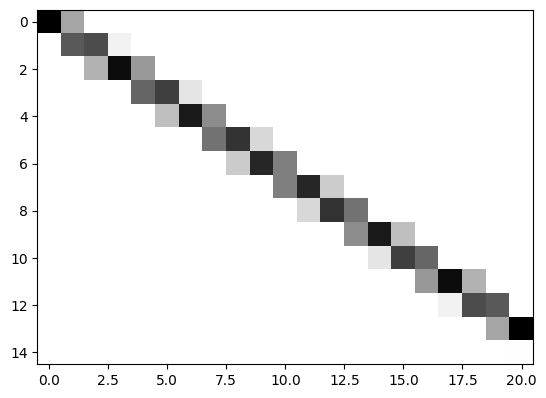

In [18]:
line = smooth_line(0, 0, 20, 13)
line_arr = np.full((15, 21, 3), 255, dtype=np.int32)
for p in line:
    c = int((1-p[2]) * 255)
    line_arr[p[1], p[0]] = np.array([c, c, c])
pic = plt.imshow(line_arr, vmin=0, vmax=255, interpolation=None)

For comparison, I am also adding the Bresenham algorithm which does not perform any anti-aliasing.

In [19]:
def bresenham_line(x0: int, y0: int, x1: int, y1: int):
    line = []
    
    dx = x1 - x0
    dy = y1 - y0
    
    if dy < 0:
        dy = -dy
        step_y = -1
    else:
        step_y = 1
    
    if dx < 0:
        dx = -dx
        step_x = -1
    else:
        step_x = 1
        
    dy = 2 * dy
    dx = 2 * dx
    
    line.append((x0, y0))
    
    if dx > dy:
        fraction = dy - (dx // 2)
        
        while x0 != x1:
            x0 += step_x
            if fraction >= 0:
                y0 += step_y
                fraction -= dx
            fraction += dy
            line.append((x0, y0))
    else:
        fraction = dx - (dy // 2)
        
        while y0 != y1:
            if fraction >= 0:
                x0 += step_x
                fraction -= dy
            y0 += step_y
            fraction += dx
            line.append((x0, y0))
    return line

In [20]:
line = bresenham_line(0, 0, 20, 13)
line_arr = np.full((15, 21, 3), 255, dtype=np.int32)
for p in line:
    c = 0
    line_arr[p[1], p[0]] = np.array([c, c, c])

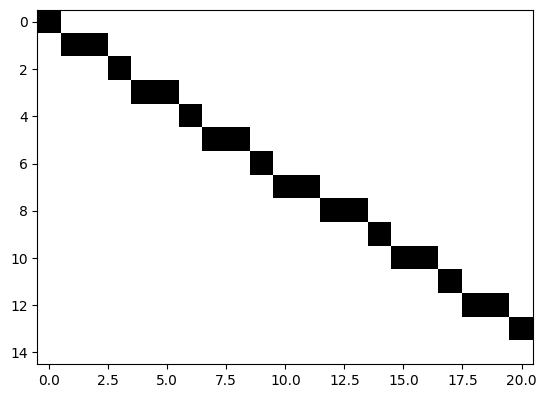

In [21]:
_ = plt.imshow(line_arr, vmin=0, vmax=255, interpolation=None)

This function converts tile coordinates at a given detail level to an integer-encoded quadkey.

In [22]:
@jit(nopython=True)
def tile_to_qk(x, y, level):
    """
    Converts tile coordinates to a quadkey
    Code adapted from https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
    :param x: Tile x coordinate
    :param y: Tile y coordinate
    :param level: Detail leve;
    :return: QuadKey
    """
    q = numba.types.uint64(0)
    for i in range(level, 0, -1):
        mask = 1 << (i - 1)

        q = q << 2
        if (x & mask) != 0:
            q += 1
        if (y & mask) != 0:
            q += 2
    return q

This function converts tile coordinates at a given detail level to a string-encoded quadkey.

In [23]:
@jit(nopython=True)
def tile_to_str(x, y, level):
    """
    Converts tile coordinates to a quadkey
    Code adapted from https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
    :param x: Tile x coordinate
    :param y: Tile y coordinate
    :param level: Detail leve;
    :return: QuadKey
    """
    q = ""
    for i in range(level, 0, -1):
        mask = 1 << (i - 1)

        c = 0
        if (x & mask) != 0:
            c += 1
        if (y & mask) != 0:
            c += 2
        q = q + str(c)
    return q

The `get_qk_line` function draws a line between the given endpoints (expressed in latitude and longitude coordinates) into a sequence of tuples containing the quadkey and its weight.

In [24]:
def get_qk_line(loc0, loc1, level):
    qk0 = quadkey.from_geo((loc0['y'], loc0['x']), level)
    qk1 = quadkey.from_geo((loc1['y'], loc1['x']), level)
    
    ((tx0, ty0), _) = qk0.to_tile()
    ((tx1, ty1), _) = qk1.to_tile()

    line = smooth_line(tx0, ty0, tx1, ty1)
    return [(quadkey.from_str(tile_to_str(p[0], p[1], level)), p[2]) for p in line if p[2] > 0.0]

The `map_route_qk` function generates a map with the generated route and overlays the _drawn_ quadkeys.

In [25]:
def map_route_qk(g, route, level=20):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        lat = loc['y']
        lon = loc['x']
        CircleMarker((lat, lon), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((lat, lon))
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
        for qk, weight in get_qk_line(l0, l1, level):
            create_map_quadkey(qk, color="green", opacity=weight).add_to(html_map)
            # print(qk.to_quadint() >> (64-2*level), edge[0]['bearing'])
            
    return fit_bounding_box(html_map, bb_list)    

In [26]:
map_route_qk(g, route)

This function queries a specific quadkey for speed vectors that align with a given bearing and at a given time slot.

In [27]:
def get_quadkey_speeds(db, qk_int, bearing, week_day, day_slot, angle_delta = 5.0):
    sql = """
    select speed
    from   signal
    where  quadkey = ? and 
           cos(radians(bearing - ?)) >= cos(radians(?)) and
           week_day = ? and day_slot = ?;
    """
    speeds = db.query(sql, [qk_int, bearing, angle_delta, week_day, day_slot])
    if speeds is None:
        return []
    elif len(speeds):
        return [v[0] for v in speeds if v is not None]
    else:
        return []

The `infer_edge_time` computes the duration of travelling through an edge by querying all _anti-aliased drawn_ quadkeys.

In [28]:
def infer_edge_time(g, node_ini, node_end, week_day, time_s, level=20):
    db = EVedDb()
    edge = g[node_ini][node_end]
    bearing = edge[0]['bearing']
    distance = edge[0]['length']
    day_slot = int(time_s / 600)
    
    location_ini = g.nodes[node_ini]
    location_end = g.nodes[node_end]

    speeds = []
    total_weight = 0.0
    line = get_qk_line(location_ini, location_end, level)
    for qk, weight in line:
        qk_int = qk.to_quadint() >> (64-2*level)
        qk_speeds = get_quadkey_speeds(db, qk_int, bearing, week_day, day_slot)
        
        if qk_speeds is not None and len(qk_speeds):
            speeds.extend([s * weight for s in qk_speeds if s is not None])
            total_weight += weight
            
    duration_s = edge[0]['travel_time']
    if len(speeds) > 0:
        speed_kmh = np.average(np.array(speeds)) / total_weight
        speed_ms = speed_kmh / 3.6
        if speed_ms > 0:
            duration_s = distance / speed_ms
        
    return duration_s

Infer the total route time using the week day and day time. Note that the function increments the day if needed.

In [29]:
def infer_route_time(g, route, week_day, hours=12, minutes=0):
    seconds_in_day = 24 * 60 * 60
    time_s = (hours * 60 + minutes) * 60
    duration_s = 0
    for n0, n1 in pairwise(route):
        d = infer_edge_time(g, n0, n1, week_day, time_s)
        time_s += d
        duration_s += d
        
        if time_s > seconds_in_day:
            time_s -= seconds_in_day
            week_day = (week_day + 1) % 7
    return duration_s

This function aggregates the route's edges travel time.

In [30]:
def default_route_time(g, route):
    duration_s = 0
    for node_ini, node_end in pairwise(route):
        edge = g[node_ini][node_end]
        duration_s += edge[0]['travel_time']
    return duration_s

In [31]:
def_time = default_route_time(g, route)
def_time // 3600, def_time // 60

(0.0, 5.0)

In [32]:
route_time = infer_route_time(g, route, week_day=1, hours=23, minutes=0)
route_time // 3600, route_time // 60

OperationalError: no such function: radians

## Chart the Route Durations

We now see how the route duration varies throughout the day.

In [ ]:
def reformat_time_labels(labels):
    slots = [int(l.replace('−', '-')) for l in labels]
    labels = [f"{int(s/6):02}:{int((s/6 - int(s/6))*60+0.5):02}" for s in slots]
    return labels

In [ ]:
def reformat_duration_labels(labels):
    slots = [int(l.replace('−', '-')) for l in labels]
    labels = [f"{int(s/60):02}:{int((s/60 - int(s/60))*60+0.5):02}" for s in slots]
    return labels

In [ ]:
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

In [ ]:
xs = np.linspace(0, 143, num=144)
ys = np.zeros_like(xs)

week_day = 1
i = 0
for hour in tqdm(range(24)):
    for slot in range(6):
        ys[i] = infer_route_time(g, route, week_day, hours=hour, minutes=slot * 10)
        i += 1

In [ ]:
fig, ax = plt.subplots()
ax.plot(xs, ys)
x_labels = reformat_time_labels([item.get_text() for item in ax.get_xticklabels()])
y_labels = reformat_duration_labels([item.get_text() for item in ax.get_yticklabels()])
_ = ax.set_xticklabels(x_labels)
_ = ax.set_yticklabels(y_labels)
plt.xlabel("Time of day (hh:mm)")
plt.ylabel("Trip duration (mm:ss)")
plt.title(weekdays[week_day])

Now, let's see how the weekly average behaves.

In [ ]:
xs = np.linspace(0, 143, num=144)
ys = np.zeros_like(xs)

week_day = 0
i = 0
for hour in tqdm(range(24)):
    for slot in range(6):
        for week_day in range(7):
            ys[i] += infer_route_time(g, route, week_day, hours=hour, minutes=slot * 10)
        ys[i] /= 7
        i += 1

In [ ]:
fig, ax = plt.subplots()
ax.plot(xs, ys)
x_labels = reformat_time_labels([item.get_text() for item in ax.get_xticklabels()])
y_labels = reformat_duration_labels([item.get_text() for item in ax.get_yticklabels()])
_ = ax.set_xticklabels(x_labels)
_ = ax.set_yticklabels(y_labels)
plt.xlabel("Time of day (hh:mm)")
plt.ylabel("Trip duration (mm:ss)")
plt.title("Weekly Average")

## Speed Coloring

Here we draw the route using colors that reflect the actual speed in comparison to the map speed.

In [ ]:
def map_route_speed(g, route, week_day, hours, minutes):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    bb_list = []
    seconds_in_day = 24 * 60 * 60
    time_s = (hours * 60 + minutes) * 60
    duration_s = 0
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        edge_s = edge[0]['travel_time']

        d = infer_edge_time(g, n0, n1, week_day, time_s)
        time_s += d
        duration_s += d
        
        if time_s > seconds_in_day:
            time_s -= seconds_in_day
            week_day = (week_day + 1) % 7
            
        factor = d / edge_s
        
        if factor < 1.0:
            color = "lightgreen"
        elif factor < 1.22:
            color = "green"
        elif factor < 1.8:
            color = "orange"
        else:
            color = "red"

        PolyLine(line, weight=3, opacity=1, color=color).add_to(html_map)
        
        bb_list.extend(line)
            
    return fit_bounding_box(html_map, bb_list)    

In [ ]:
map_route_speed(g, route, week_day=1, hours=21, minutes=0)